# InSituPy demonstration - Performance tests

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import read_xenium
from datetime import datetime
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
## Import the custom library
import os
import sys

# add paths of all repositories that are supposed to be added to following list
module_paths = [r"C:\Users\ge37voy\Github\CustomFunctions"]

for path in module_paths:
    if path not in sys.path:
        sys.path.append(os.path.abspath(path))

import custom_palettes as cp

In [4]:
palettes = cp.CustomPalettes()

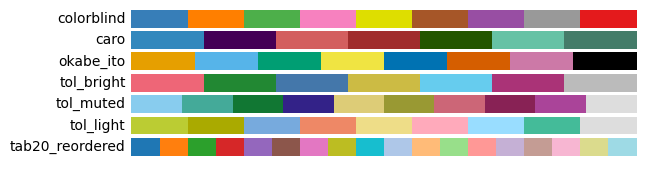

In [5]:
palettes.show_all()

## Load Xenium data into `InSituData` object

In [6]:
insitupy_project = Path("../demo_dataset/demo_insitupy_project")

In [7]:
xd = read_xenium(insitupy_project)

In [8]:
xd.load_all()

Loading annotations...
Loading cells...
	No alternative cells found...
Loading images...
Loading regions...
Loading transcripts...


## Test writing data to disk

In [9]:
pixel_size = xd.images.metadata["nuclei"]["pixel_size"]
shape_um = tuple([elem * pixel_size for elem in xd.images.nuclei[0].shape])
center = tuple([int(elem / 2) for elem in shape_um])

In [10]:
# parameters
square_width_list = [4000, 2000, 1000, 500, 250]
n_replicates = 3
out_dir = Path("./out")

dt_list_save = []
for _ in range(n_replicates):
    # delete existing output directories
    if out_dir.exists():
        print("Delete existing output directory...")
        shutil.rmtree(out_dir)

    # append empty list to collect results
    dt_list_save.append([])
    for square_width in square_width_list:
        t0 = datetime.now()
        xlim = (int(center[1] - square_width / 2), int(center[1] + square_width / 2))
        ylim = (int(center[0] - square_width / 2), int(center[0] + square_width / 2))

        # crop data
        xd_cropped = xd.crop(xlim=xlim, ylim=ylim)

        # save data
        xd_cropped.saveas(out_dir / f"crop{square_width}")
        t1 = datetime.now()
        dt_list_save[-1].append(t1 - t0)

Delete existing output directory...
Saving data to out\crop4000
Saved.
Saving data to out\crop2000
Saved.
Saving data to out\crop1000
Saved.
Saving data to out\crop500
Saved.
Saving data to out\crop250
Saved.
Delete existing output directory...
Saving data to out\crop4000
Saved.
Saving data to out\crop2000
Saved.
Saving data to out\crop1000
Saved.
Saving data to out\crop500
Saved.
Saving data to out\crop250
Saved.
Delete existing output directory...
Saving data to out\crop4000
Saved.
Saving data to out\crop2000
Saved.
Saving data to out\crop1000
Saved.
Saving data to out\crop500
Saved.
Saving data to out\crop250
Saved.


In [11]:
dt_list_save_sec = [[elem.total_seconds() for elem in l] for l in dt_list_save]

In [12]:
df_save = pd.DataFrame(dt_list_save_sec, columns=square_width_list).T
df_save = df_save.reset_index(names="Square width [µm]").melt(id_vars="Square width [µm]", var_name="Replicates", value_name="Time [s]")

C:\Users\ge37voy\AppData\Local\Temp\ipykernel_2356\2599256221.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(df_save, x="Square width [µm]", y="Time [s]", palette=palettes.okabe_ito)


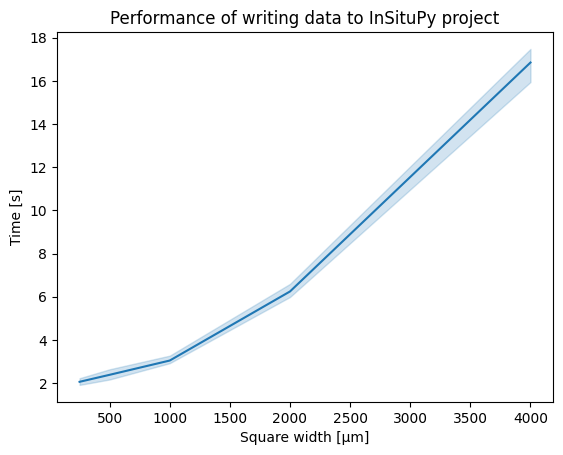

In [22]:
sns.lineplot(df_save, x="Square width [µm]", y="Time [s]", palette=palettes.okabe_ito)
plt.title("Performance of writing data to InSituPy project")
plt.savefig("figures/lineplot_performance_write.pdf")
plt.show()

## Loading performance

In [14]:
dt_names = ["Metadata", "Images", "Cells", "Transcripts"]
dt_list_load = []
for square_width in square_width_list:
    path = out_dir / f"crop{square_width}"
    t_list = [datetime.now()]
    xd = read_xenium(path)
    t_list.append(datetime.now())
    xd.load_images()
    t_list.append(datetime.now())
    xd.load_cells()
    t_list.append(datetime.now())
    xd.load_transcripts()
    t_list.append(datetime.now())

    # save results
    dt_list = [t_list[i+1] - t_list[i] for i in range(len(t_list)-1)]
    dt_list = [elem.total_seconds() for elem in dt_list]
    dt_list_load.append(dt_list)

Loading images...
Loading cells...
	No alternative cells found...
Loading transcripts...
Loading images...
Loading cells...
	No alternative cells found...
Loading transcripts...
Loading images...
Loading cells...
	No alternative cells found...
Loading transcripts...
Loading images...
Loading cells...
	No alternative cells found...
Loading transcripts...
Loading images...
Loading cells...
	No alternative cells found...
Loading transcripts...


In [15]:
df_load = pd.DataFrame(dt_list_load, index=square_width_list, columns=dt_names).reset_index(names="Square width [µm]")
df_load = df_load.sort_values("Square width [µm]")
df_load = df_load.drop("Metadata", axis=1)
df_load_melt = df_load.melt(id_vars="Square width [µm]", var_name="Data type", value_name="Time [s]")

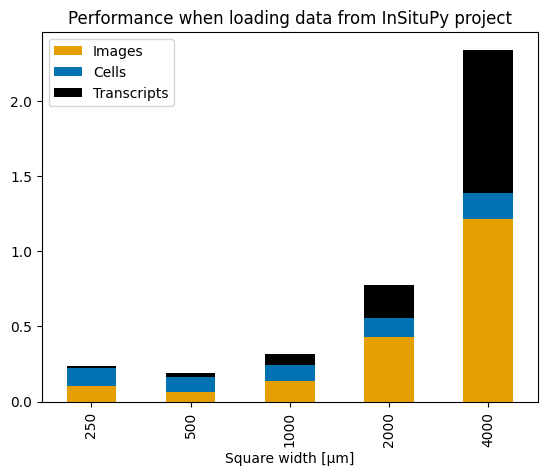

In [25]:
df_load.plot(kind='bar', stacked=True, x="Square width [µm]", colormap=palettes.okabe_ito)
plt.title("Performance when loading data from InSituPy project")
plt.savefig("figures/barplot_performance_load.pdf", bbox_inches="tight")
plt.show()

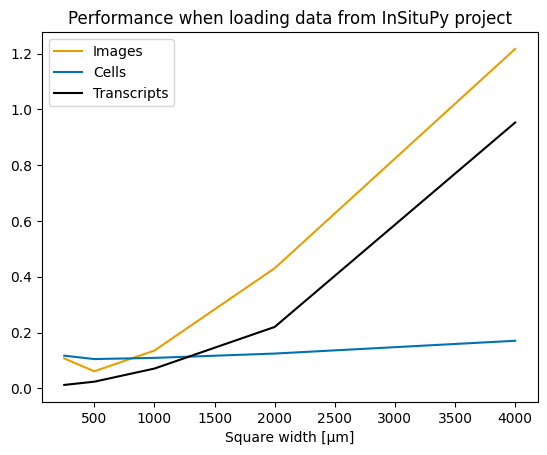

In [24]:
df_load.plot(kind='line', x="Square width [µm]", colormap=palettes.okabe_ito)
plt.title("Performance when loading data from InSituPy project")
plt.savefig("figures/lineplot_performance_load.pdf")
plt.show()